In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# # Dataset
# import zipfile

# z = zipfile.ZipFile('archive.zip')

# z.extractall()

In [5]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [7]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


# EDA(Exploratory Data Analysis)

In [8]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


# Plot

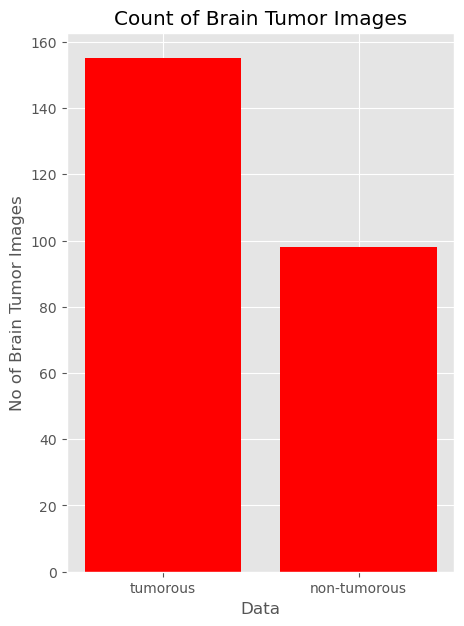

In [9]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Augmentation

In [ ]:

# 155(61%), 98(39%)
# imbalance

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [11]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [12]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [13]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes' 
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:15.265000343322754


In [14]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [15]:
data_summary(augmented_data_path)

Number of sample: 2064
1085 Number of positive sample in percentage: 52.56782945736434%
979 Number of negative sample in percentage: 47.43217054263566%


In [16]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
979


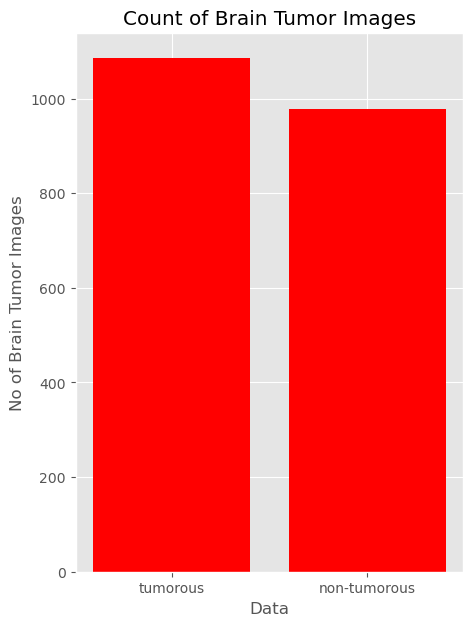

In [17]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Preprocessing

In [ ]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [18]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image
    

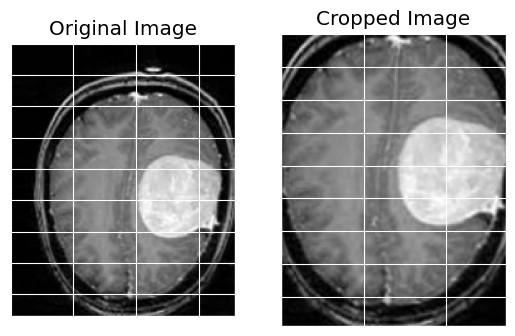

array([[[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 6,  6,  6],
        [ 4,  4,  4],
        [ 2,  2,  2]],

       [[ 4,  4,  4],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 6,  6,  6]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [12, 12, 12],
        [ 9,  9,  9],
        [ 0,  0,  0]],

       ...,

       [[ 4,  4,  4],
        [ 6,  6,  6],
        [ 5,  5,  5],
        ...,
        [ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       [[ 2,  2,  2],
        [ 4,  4,  4],
        [ 3,  3,  3],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 1,  1,  1],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 8,  8,  8],
        [ 9,  9,  9],
        [10, 10, 10]]], dtype=uint8)

In [20]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_1417.jpg')
crop_brain_tumor(img, True)

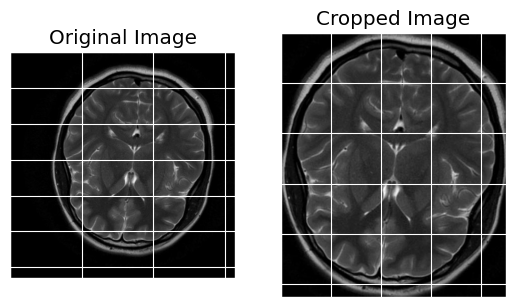

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [21]:
img = cv2.imread('augmented_data/no/aug_N_1_0_57.jpg')
crop_brain_tumor(img, True)

In [23]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

# Image Loading

In [24]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y
            

In [25]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [26]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

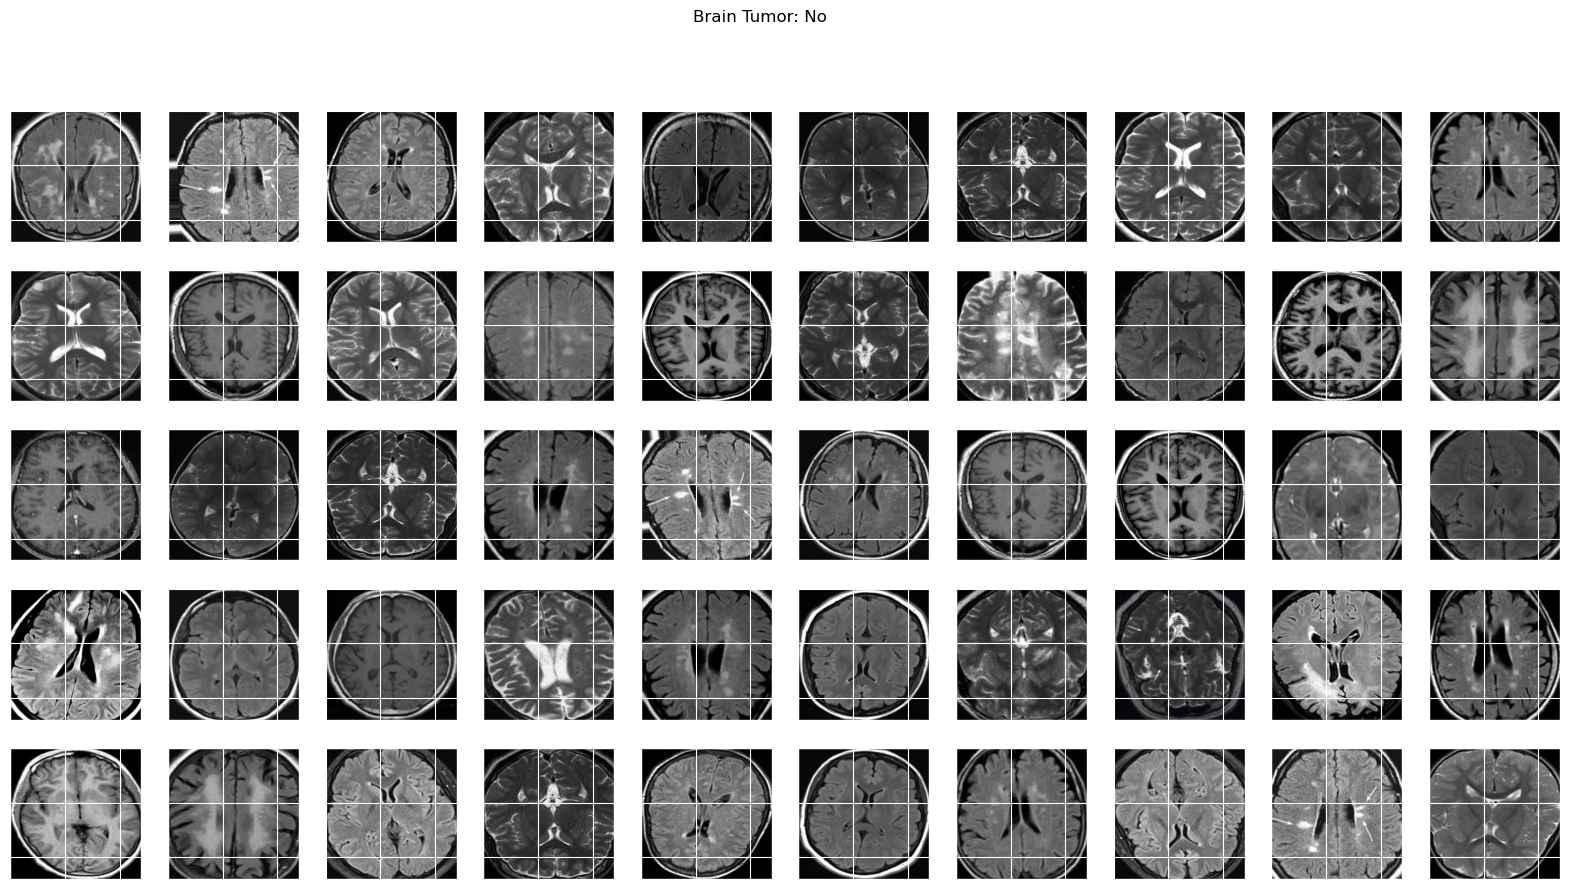

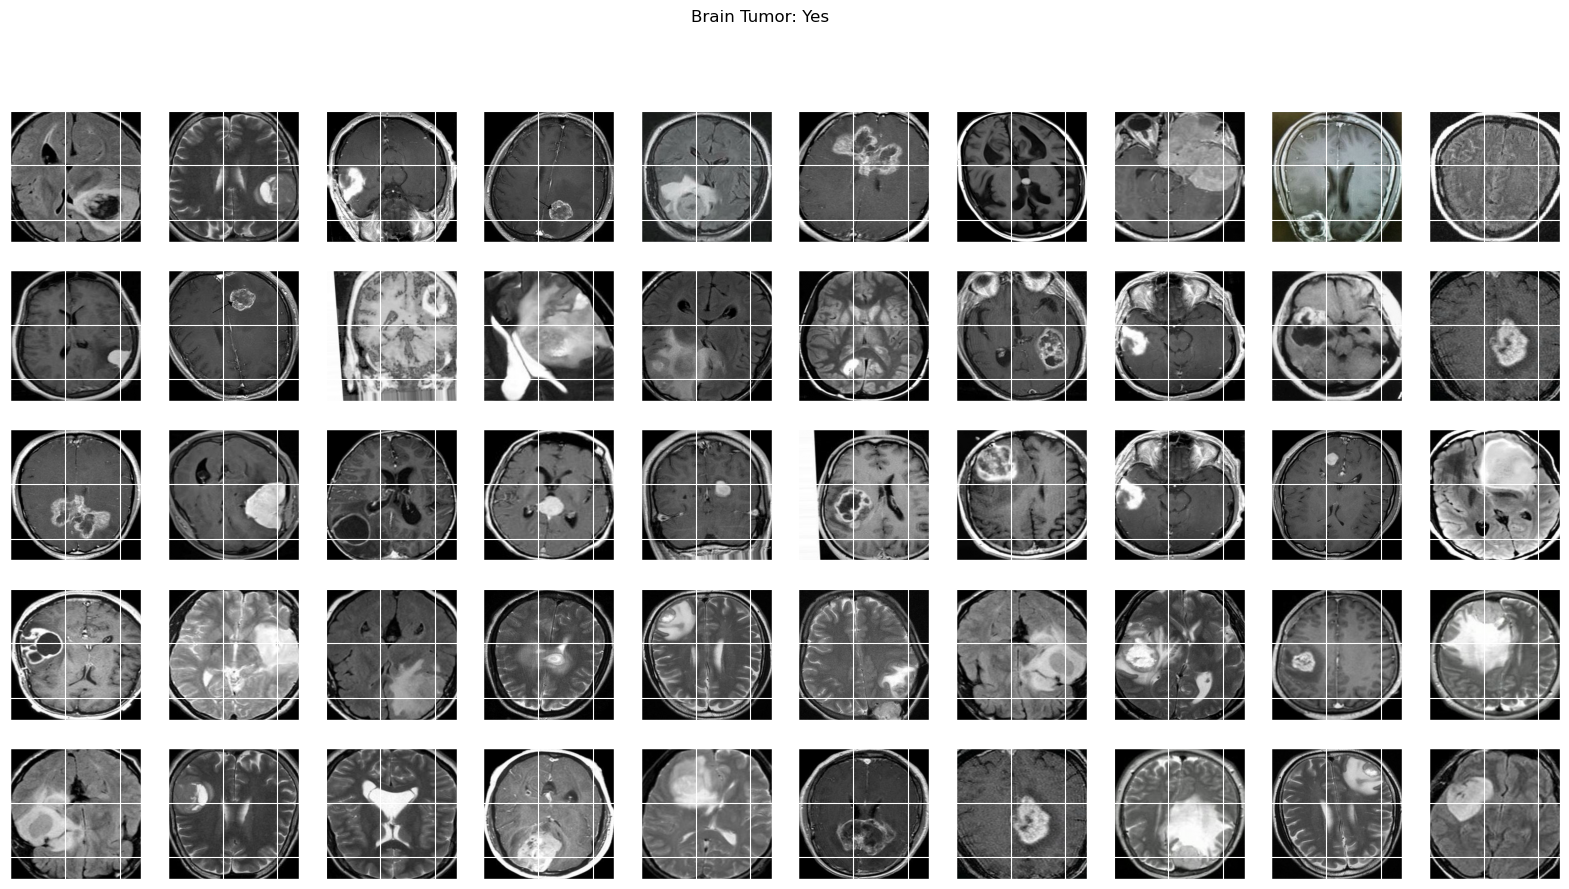

In [27]:
plot_sample_images(X,y)

# Data Spliting

In [43]:

# Train
# Test
# Validation

In [28]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [30]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [31]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [32]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [33]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [34]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [35]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [36]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [88]:
# 70% 15% 15%

In [37]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [38]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [39]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

# Model Buliding

In [40]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [41]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [42]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [43]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 308 images belonging to 2 classes.


In [44]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [45]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [46]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [47]:
# callback
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [48]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [51]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.5290
Epoch 1: val_loss improved from 0.67934 to 0.66920, saving model to model.h5
10/10 [==============================] - 68s 7s/step - loss: 0.7078 - accuracy: 0.5290 - val_loss: 0.6692 - val_accuracy: 0.5779 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5562
Epoch 2: val_loss improved from 0.66920 to 0.66351, saving model to model.h5
10/10 [==============================] - 70s 7s/step - loss: 0.6870 - accuracy: 0.5562 - val_loss: 0.6635 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6062
Epoch 3: val_loss did not improve from 0.66351
10/10 [==============================] - 72s 8s/step - loss: 0.6675 - accuracy: 0.6062 - val_loss: 0.6643 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6445 - ac

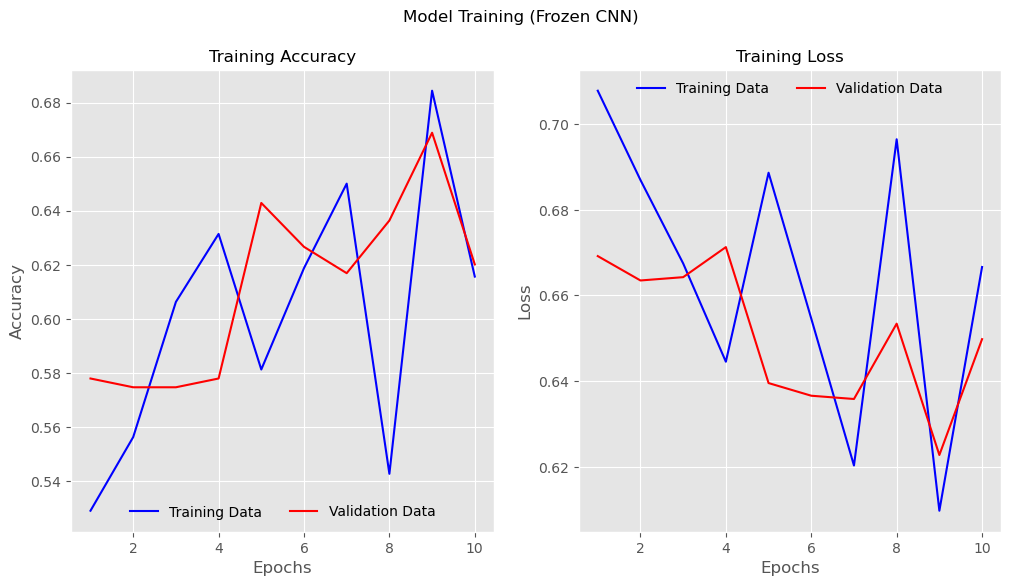

In [52]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [53]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [54]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 [==============================] - 30s 3s/step - loss: 0.6866 - accuracy: 0.5226


In [55]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6324473023414612
Validation Acc: 0.6558441519737244
Testing Loss: 0.6866472363471985
Testing Acc: 0.522580623626709


In [56]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 [==============================] - 30s 87ms/step


# Increamental unfreezing and fine tuning

In [57]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [58]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [59]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [62]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.6438
Epoch 1: val_loss did not improve from 0.60986
10/10 [==============================] - 67s 7s/step - loss: 0.6355 - accuracy: 0.6438 - val_loss: 0.6253 - val_accuracy: 0.6623 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.6553
Epoch 2: val_loss did not improve from 0.60986
10/10 [==============================] - 63s 7s/step - loss: 0.6324 - accuracy: 0.6553 - val_loss: 0.6130 - val_accuracy: 0.6916 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6143
Epoch 3: val_loss improved from 0.60986 to 0.58989, saving model to model.h5
10/10 [==============================] - 64s 7s/step - loss: 0.6461 - accuracy: 0.6143 - val_loss: 0.5899 - val_accuracy: 0.6981 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.6938
Epoch 4: val_lo

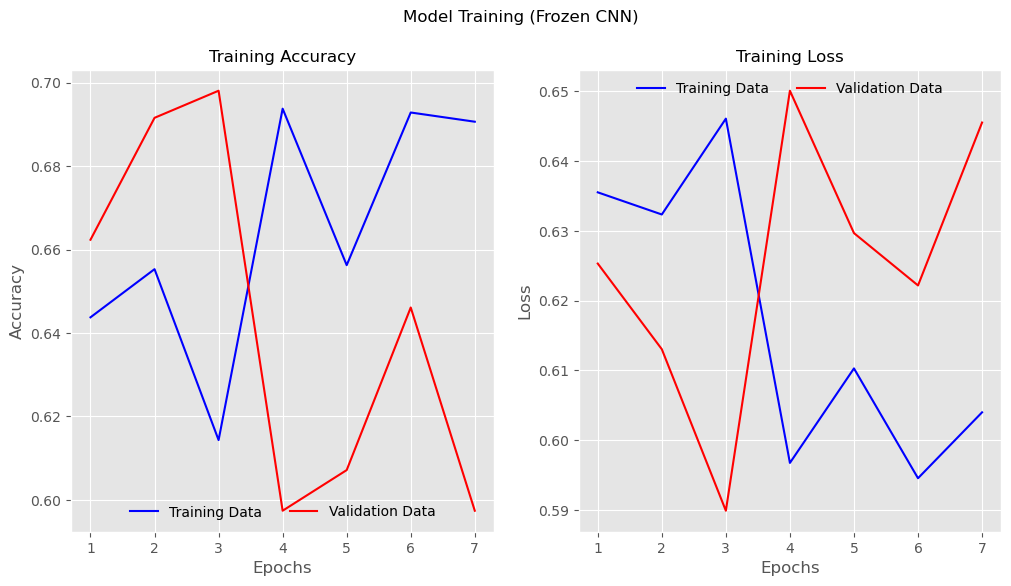

In [64]:
import matplotlib.pyplot as plt

# Plot performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

# Fix the max_epoch and epochs_list using the correct history object
max_epoch = len(history_02.history['accuracy'])  # Get max epochs from history_02
epochs_list = list(range(1, max_epoch + 1))  # Create a list of epochs

# Plot accuracy
ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

# Plot loss
ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

# Save the plot
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

# Show plot
plt.show()


In [65]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.h5", overwrite=True)

In [66]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 [==============================] - 31s 3s/step - loss: 0.6227 - accuracy: 0.6581


In [ ]:
# Unfreezing the entire network

In [67]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [68]:
model_03.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [69]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7031 
Epoch 1: val_loss did not improve from 0.58989
10/10 [==============================] - 157s 16s/step - loss: 0.5835 - accuracy: 0.7031 - val_loss: 0.6444 - val_accuracy: 0.6169 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.6485 
Epoch 2: val_loss did not improve from 0.58989
10/10 [==============================] - 142s 14s/step - loss: 0.6165 - accuracy: 0.6485 - val_loss: 0.5983 - val_accuracy: 0.6753 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6724 
Epoch 3: val_loss improved from 0.58989 to 0.56295, saving model to model.h5
10/10 [==============================] - 144s 15s/step - loss: 0.6095 - accuracy: 0.6724 - val_loss: 0.5630 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7312 
Epoch

In [70]:
model_03.load_weights("model_weights/vgg_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 [==============================] - 31s 3s/step - loss: 0.2716 - accuracy: 0.9097


2.10.0
